# MRI Dementia Classification - Load Pre-Saved Models
This model is used for MRI classification of dementia with 4 known stages (Non-Demented, Mild Demented, Moderate Demented and Very Mild Demented). Severe onset dementia is known as Alzheimer's Disease which will not be covered in this analysis. All data sourced from https://www.kaggle.com/datasets/matthewhema/mri-dementia-augmentation-no-data-leak

In [56]:
# Import Dependencies and Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPooling2D, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [57]:
# Load MRI Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("matthewhema/mri-dementia-augmentation-no-data-leak")

print("Path to dataset files:", path)

Path to dataset files: /Users/mattle/.cache/kagglehub/datasets/matthewhema/mri-dementia-augmentation-no-data-leak/versions/1


## Image Processing

Here we're leveraging a function called ImageDataGenerator() from the Tensor library to combine all of the operations of rescaling, setting our target size, batch size, etc to prep them into respective bins - Train, Test and Validation. 

In [58]:
# Set local data paths
train_dir = path + '/Train/Train'
val_dir = path + '/Val/Val'
test_dir = path + '/Test/Test'

# Store ImageDataGenerator parameters in a dictionary
imageDataGenerator_params = {
    'rescale': 1./255,
    'rotation_range': 20,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'fill_mode': 'nearest'   
}

In [59]:
# Image Generators Variables

# Resize all input images to 224x224
image_size = (224, 224)

#Number of images the model processes before updating weights
batch_size = 32

# Set the color space
color_mode = 'rgb'

# Define the class order
class_order = ['Non Demented', 'Very MildDemented', 'Mild Demented', 'Moderate Demented']

In [60]:
# Rescaling [0,1] for neural networks to process normalized values
train_datagen = ImageDataGenerator(imageDataGenerator_params)
val_datagen = ImageDataGenerator(imageDataGenerator_params)
test_datagen = ImageDataGenerator(imageDataGenerator_params)

# Create Generators for Train, Val and Test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    color_mode=color_mode,
    classes=class_order,
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    color_mode=color_mode,
    classes=class_order,
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    color_mode=color_mode,
    classes=class_order,
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=True
)


Found 11350 images belonging to 4 classes.
Found 960 images belonging to 4 classes.
Found 960 images belonging to 4 classes.


### Visualize the data 

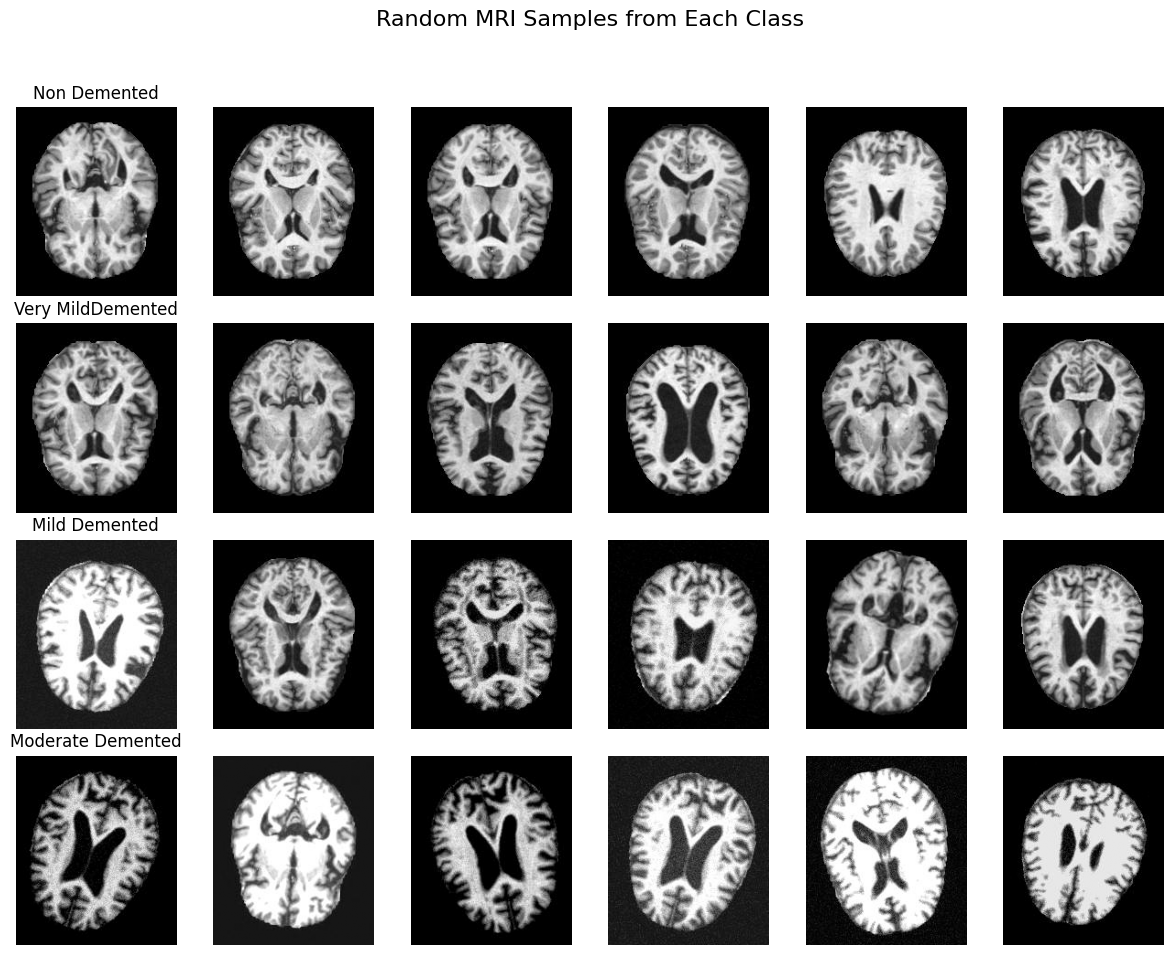

In [ ]:
# Corresponding actual folder names in the dataset
folder_map = {
    'Non Demented': 'Non Demented',
    'Very MildDemented': 'Very MildDemented',
    'Mild Demented': 'Mild Demented/Mild Demented Merge',
    'Moderate Demented': 'Moderate Demented/Moderate Demented Merge'
}

# Update this to your dataset's base folder path
base_dir = path + '/Train/Train'

# Set up subplots
fig, axes = plt.subplots(len(class_order), 6, figsize=(12, 10))
if len(class_order) == 1:
    axes = np.expand_dims(axes, axis=0)

fig.suptitle('Random MRI Samples from Each Class', fontsize=16)

for row_idx, label in enumerate(class_order):
    folder_name = folder_map[label]
    class_path = os.path.join(base_dir, folder_name)

    if not os.path.exists(class_path):
        print(f"Directory not found for: {folder_name}")
        continue

    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(image_files) == 0:
        print(f"No images found in folder: {folder_name}")
        continue

    # Safe sampling (with replacement if fewer than 6)
    sampled_files = random.choices(image_files, k=min(6, len(image_files)))

    for col_idx in range(6):
        ax = axes[row_idx, col_idx]
        ax.axis('off')

        if col_idx < len(sampled_files):
            img_path = os.path.join(class_path, sampled_files[col_idx])
            image = mpimg.imread(img_path)
            ax.imshow(image, cmap='gray')
            if col_idx == 0:
                ax.set_title(label)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [62]:
# Check the class indices for each generator
train_class_indices = train_generator.class_indices
val_class_indices = val_generator.class_indices
test_class_indices = test_generator.class_indices

# Print the class indices
print("Train Class indices:", train_class_indices)
print("Validation Class indices:", val_class_indices)
print("Test Class indices:", test_class_indices)

# Check color space
print(train_generator.image_shape)  # should be (224, 224, 3)

Train Class indices: {'Non Demented': 0, 'Very MildDemented': 1, 'Mild Demented': 2, 'Moderate Demented': 3}
Validation Class indices: {'Non Demented': 0, 'Very MildDemented': 1, 'Mild Demented': 2, 'Moderate Demented': 3}
Test Class indices: {'Non Demented': 0, 'Very MildDemented': 1, 'Mild Demented': 2, 'Moderate Demented': 3}
(224, 224, 3)


## Load the Model and History files

In [63]:
# Load the model
model = load_model('saved_models/dementia_cnn_sequential_1_model_V5.keras')

In [64]:
# Load the pickle file into history
import pickle

with open('saved_models/dementia_cnn_sequential_1_history_V5.pkl', 'rb') as f:
    history_dict = pickle.load(f)

class History:
    def __init__(self, history):
        self.history = history

history = History(history_dict)

### Run the Model on Test data

In [65]:
%%time
# Evaluation on Test Set
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2f}")

# Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.9421 - loss: 0.1631
Test Accuracy: 0.94
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step
CPU times: user 57.2 s, sys: 6.57 s, total: 1min 3s
Wall time: 12.5 s


### Analysis of Results

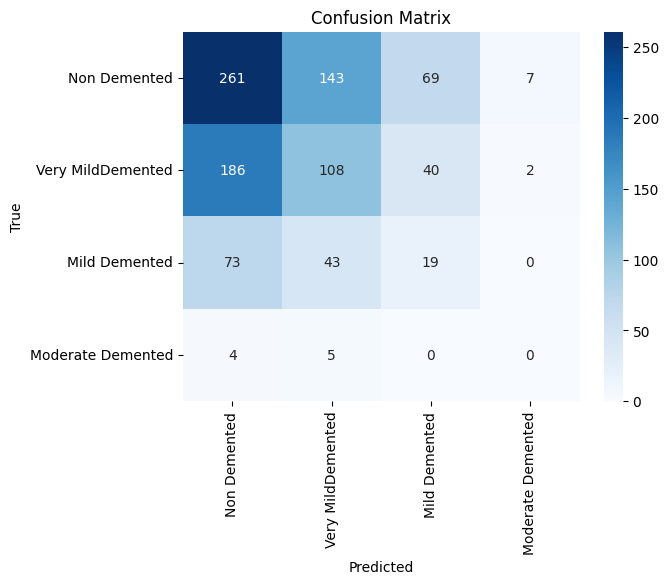

              precision    recall  f1-score   support

           0       0.50      0.54      0.52       480
           1       0.36      0.32      0.34       336
           2       0.15      0.14      0.14       135
           3       0.00      0.00      0.00         9

    accuracy                           0.40       960
   macro avg       0.25      0.25      0.25       960
weighted avg       0.40      0.40      0.40       960



In [66]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred_classes))

In [67]:
# Print the number of images in each class - non and very mild are weighing the dataset down. 
import collections
print(collections.Counter(test_generator.classes))

Counter({np.int32(0): 480, np.int32(1): 336, np.int32(2): 135, np.int32(3): 9})


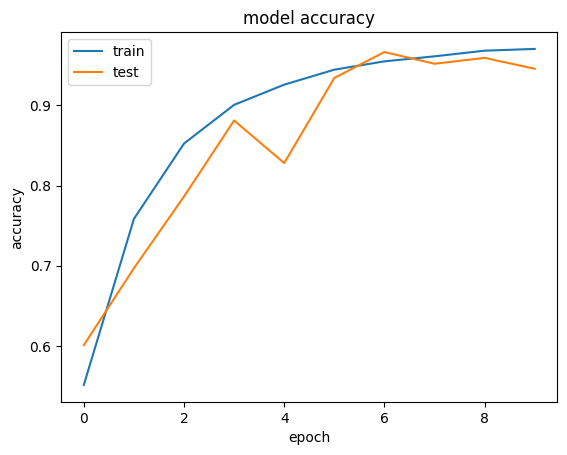

In [68]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

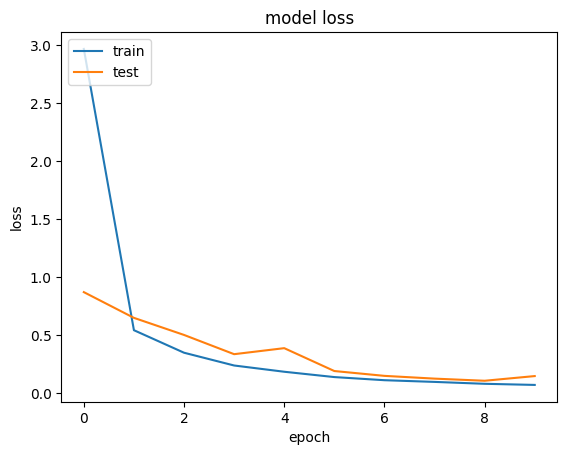

In [69]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predict on a Single Image

In [70]:
def predict_single_image(image_path):
    # Load image as grayscale and resize
    img = load_img(image_path, color_mode='rgb', target_size=(224, 224))

    # Convert to array 
    img_array = img_to_array(img)

    # Normalize and add batch dimension
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(img_array)
    predicted_index = np.argmax(preds)
    confidence = float(np.max(preds))

    # Update with your class labels
    predicted_label = class_order[predicted_index]

    # Output
    print(f"Predicted class: {predicted_label}")
    print(f"Confidence: {confidence:.2f} ({confidence*100:.2f}%)")
    print("Softmax output:", preds)

    # Plot confidence for all classes
    plt.figure(figsize=(8, 4))
    plt.bar(class_order, preds[0])
    plt.title("Prediction Confidence per Class")
    plt.ylabel("Probability")
    plt.ylim(0, 1)
    plt.show()

    return predicted_label, confidence, preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted class: Very MildDemented
Confidence: 0.31 (31.15%)
Softmax output: [[0.2995843  0.3115345  0.2228004  0.16608086]]


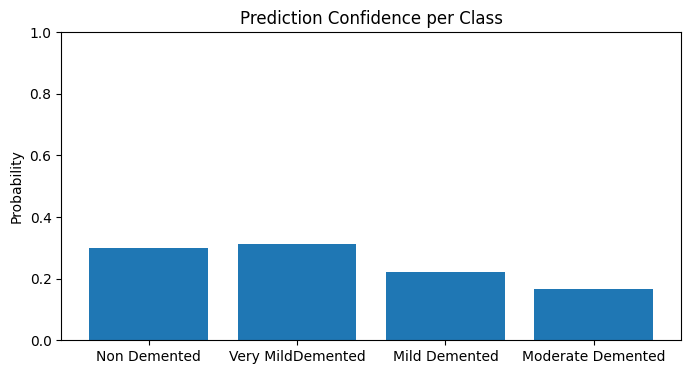

('Very MildDemented',
 0.31153449416160583,
 array([[0.2995843 , 0.3115345 , 0.2228004 , 0.16608086]], dtype=float32))

In [71]:
# Predict a single image
predict_single_image("saved_models/nonDem1422.jpg")